In [1]:
from sentinelhub import BBox, CRS, DataCollection, SHConfig
from eolearn.core import SaveTask, FeatureType, LinearWorkflow, EOPatch,OverwritePermission
from eolearn.io import SentinelHubInputTask
import geopandas as gpd
import datetime
from typing import Type
import numpy as np
import sys

/Users/sanchit/anaconda3/lib/python3.7/site-packages/eolearn/io/processing_api.py:176: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ProcApiType("bool_mask", 'DN', 'UINT8', np.bool, FeatureType.MASK): [


In [2]:
sys.path.insert(1,'../functions')

In [144]:
import io_pipe
import nd_index
import lst
import plot_utils
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import logging

In [4]:
## add your sentinelhub credentials to start running this.
config_dict = {
            'INSTANCE_ID': None,
            'CLIENT_ID': None,
            'CLIENT_SECRET': None
        }

In [5]:
vconfig = io_pipe.set_config(new_id=True,INSTANCE_ID=config_dict['INSTANCE_ID'],
                            CLIENT_ID= config_dict['CLIENT_ID'],
                            CLIENT_SECRET=config_dict['CLIENT_SECRET'])

In [6]:
def get_landsat8_modi(aoi=None,
                 time_interval=('2020-04-10', '2020-04-28'),
                 maxcc=.15,
                 resolution=20,
                 config=None):
    """
    Download landsat8 images from sentinelhub.
    Args:
        param aoi: Area of Interest.
        type aoi: shapely.geometry.multipolygon.MultiPolygon.
        
        param time_interval: Time period want to get.
        type time_interval: two elements list. (Start, End).
        
        param maxcc: Maximum cloud coverage.
        type maxcc: float.
        
        param resolution: The resolution of images
        type resolution: int.
        
        param config: 
        type config: sentinelhub.config.SHConfig
        
    Returns:
        A eopatch datatable, which has the image data, mask data.
        image data: np.ndarray, shape(time,image_width,image_height, bands)
        mask data: np.ndarray, shape(time,image_width,image_height, 1)
    """

    if aoi is None:
        # if aoi not specificed use munich as default
        _munich = gpd.read_file('../geojson/munich.geojson')
        _interested_area = _munich.geometry.unary_union
        _bbox_interested_area = _interested_area.bounds
        _roi_bbox = BBox(bbox=_bbox_interested_area, crs=CRS.WGS84)
    else:
        if not isinstance(aoi, list) | isinstance(aoi, tuple):
            raise TypeError("Input should be List or Tuple.")
        if len(aoi) != 4:
            raise TypeError(
                "Input should be like (long_1,lati_1,long_2,lati_2).")
    if not config:
        config_dict = {
            'INSTANCE_ID': '31aacbb6-8ad8-43f5-b19d-84a8302c2a3e',
            'CLIENT_ID': '8c799cf6-53fa-4f98-a3ff-417cdc658b57',
            'CLIENT_SECRET': '13[,;5upS5%e3@oZk?J^1:)Fu?*.+0kF|,kD6re2'
        }
        config = set_config(config_dict)

    _time_difference = datetime.timedelta(hours=2)

    input_task = SentinelHubInputTask(
        data_collection=DataCollection.LANDSAT8,
        bands=[
            'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
            'B10', 'B11', 'BQA'
        ],
        bands_feature=(FeatureType.DATA, 'L1C_data'),
        additional_data=[(FeatureType.MASK, 'dataMask')],
#        size = (1000,1000),
        bands_dtype=np.int16,
        resolution=resolution,
#        additional_data=[(FeatureType.MASK, 'dataMask'),(FeatureType.META_INFO, 'META')],
        maxcc=maxcc,
        time_difference=_time_difference,
        config=config,
        max_threads=3)
    save = SaveTask('data_landsat', overwrite_permission=2, compress_level=1)
    workflow = LinearWorkflow(input_task)

    _result = workflow.execute({
        input_task: {
            'bbox': _roi_bbox,
            'time_interval': time_interval
        },
        # save: {'eopatch_folder': './landsat_eopatch'}
    })
    eopatch = _result.eopatch()

    return eopatch


In [7]:
vband = get_landsat8_modi(config=vconfig)

/Users/sanchit/anaconda3/lib/python3.7/site-packages/pandas/core/internals/construction.py:496: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
/Users/sanchit/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:411: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/Users/sanchit/anaconda3/lib/py

In [8]:
eopatch_data = vband.data['L1C_data']

In [9]:
NDVI_REF = nd_index.calc_ndvi(eopatch_data)

../functions/nd_index.py:18: RuntimeWarning: invalid value encountered in true_divide
  ndi = np.divide((band_a - band_b + c), (band_a + band_b + c))


In [117]:
vband

EOPatch(
  data: {
    L1C_data: numpy.ndarray(shape=(2, 1082, 1312, 12), dtype=int16)
  }
  mask: {
    dataMask: numpy.ndarray(shape=(2, 1082, 1312, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.15
    service_type: 'processing'
    size_x: 1312
    size_y: 1082
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2020-04-10T00:00:00', '2020-04-28T23:59:59')
  }
  bbox: BBox(((11.36078, 48.061602), (11.722878, 48.24822)), crs=CRS('4326'))
  timestamp: [datetime.datetime(2020, 4, 16, 9, 57, 9), datetime.datetime(2020, 4, 23, 10, 3, 17)]
)

In [12]:
B10 = eopatch_data[:,:,:,9]-273
B11 = eopatch_data[:,:,:,10]-273
#RADIANCE_ADD_BAND_10 = 0.10000
#RADIANCE_MULT_BAND_10 = 3.3420E-04
#K1_CONSTANT_BAND_10 = 774.8553
#K2_CONSTANT_BAND_10 = 1321.0789

In [14]:
vLSE = lst.LSE(NDVI_REF)
vLST = lst.mono_LST(B10,vLSE)

In [83]:
vR = eopatch_data[:,:,:,3]
vG = eopatch_data[:,:,:,2]
vB = eopatch_data[:,:,:,1]
vImg = np.stack([vR,vG,vB],axis =3)
vImg = (vImg *(255/  np.max(vImg))).astype(np.uint8)
vImg = (vImg*(3.5/255))

In [148]:
def plot_LST_true(True_Image,LST,date):
    # to remove the clipping warning/logging. 
    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    ## the above part is only to remove the clipping warning and has no other relevance to the plot code.
    norm = Normalize(vmin=5,vmax=np.max(LST))
    plt.rcParams['figure.figsize'] = [12, 8]    
    f, (ax1,ax2) = plt.subplots(1,2)
    im = ax2.imshow(LST,cmap=plt.cm.jet,norm=norm)
    f.colorbar(im,orientation="horizontal",fraction=0.07)
    ax1.imshow(True_Image)
    ax1.set_title(date)
    plt.show()

    

In [146]:
def plot_all_LST(True_Image,LST,date):
    assert True_Image.shape[:-1] == LST.shape
    vSze = True_Image.shape[0]
    for i in range(vSze):
        plot_LST_true(True_Image[i],LST[i],date[i])

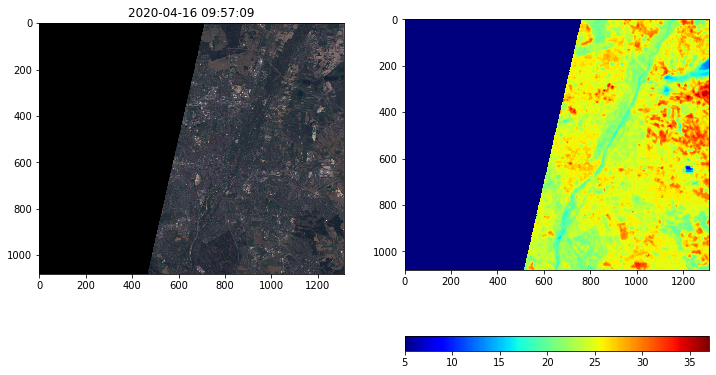

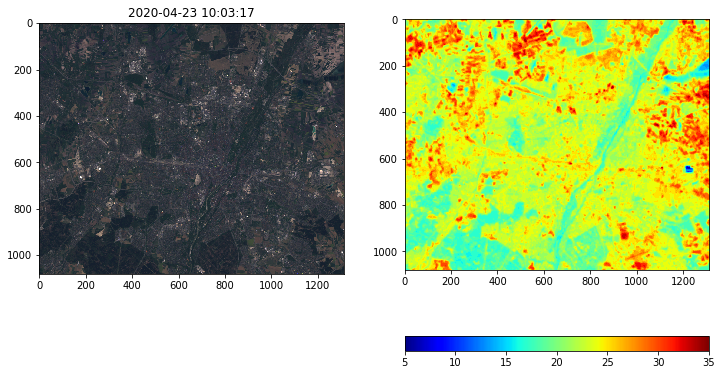

In [147]:
plot_all_LST(vImg,vLST,vband.timestamp)